"In this notebook the varname is changing!"

In [1]:
import jax
import numpyro
import blackjax
import numpy as np
import jax.numpy as jnp
import numpyro.distributions as dist
from numpyro.infer.util import initialize_model
from numpyro.infer.reparam import LocScaleReparam
from numpyro.handlers import reparam
from numpyro.infer.reparam import TransformReparam
import matplotlib.pyplot as plt

/Users/madhav/anaconda3/envs/experiment/lib/python3.11/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [2]:
# Model initialization values
J = 8
y = np.array([28.0, 8.0, -3.0, 7.0, -1.0, 1.0, 18.0, 12.0])
sigma = np.array([15.0, 10.0, 16.0, 11.0, 9.0, 11.0, 10.0, 18.0])

In [3]:
def eight_schools():
    mu = numpyro.sample('mu', dist.Normal(2, 5))
    tau = numpyro.sample('tau', dist.HalfCauchy(5))
    theta = numpyro.sample('theta', dist.Normal(jnp.full(J,mu), tau))
    numpyro.sample('obs', dist.Normal(theta, sigma), obs=y)

In [4]:
rng_key = jax.random.PRNGKey(0)

In [5]:
num_warmup = 500

adapt = blackjax.window_adaptation(blackjax.nuts, eight_schools, target_acceptance_rate=0.8)
(last_state, parameters), intermediate_states, logdensity_fn = adapt.run(rng_key, num_warmup)

In [ ]:
# New varname: theta
# Entered with varname:  theta and centeredness:  [6.8036411e-03 5.5321403e-02 3.3690915e-03 1.4231724e-05 1.8844408e-01
#  2.0367986e-01 2.6264443e-04 1.2288201e-01]
# New varname: theta_decentered
# Entered with varname:  theta_decentered and centeredness:  [3.42416205e-02 6.49751499e-02 1.00434745e-05 6.62857071e-02
#  3.60433106e-09 3.58419527e-07 8.34514946e-02 4.00610380e-02]
# New varname: theta
# Entered with varname:  theta and centeredness:  [4.0168761e-08 2.0758152e-06 7.7893310e-06 2.1325522e-07 2.2929972e-07
#  3.1783568e-07 5.4852169e-08 8.0943084e-07]
# New varname: theta_decentered
# Entered with varname:  theta_decentered and centeredness:  [0.03654923 0.00459295 0.00212589 0.002412   0.02787783 0.02531401
#  0.03658092 0.0412598 ]

In [ ]:
kernel = blackjax.nuts(logdensity_fn, **parameters).step

In [ ]:
def inference_loop(rng_key, kernel, initial_state, num_samples):
    @jax.jit
    def one_step(state, rng_key):
        state, info = kernel(rng_key, state)
        return state, (state, info)

    keys = jax.random.split(rng_key, num_samples)
    extra, (states, infos) = jax.lax.scan(one_step, initial_state, keys)

    return states, (
        infos.acceptance_rate,
        infos.is_divergent,
        infos.num_integration_steps,
    )

In [ ]:
num_sample = 1000

states, infos = inference_loop(rng_key, kernel, last_state, num_sample)
_ = states.position["mu"].block_until_ready()

In [ ]:
states[0]

{'mu': Array([ 7.16772890e+00,  7.15456963e+00,  7.73334455e+00,  7.48949623e+00,
         7.08778811e+00,  7.70670652e+00,  7.68109798e+00,  7.86349201e+00,
         8.20787716e+00,  8.26956463e+00,  7.78493786e+00,  8.11440182e+00,
         6.34498262e+00,  7.51309395e+00,  7.83398342e+00,  7.82189465e+00,
         6.80513906e+00,  2.97265983e+00,  6.39071512e+00,  2.81445575e+00,
         3.54020500e+00,  9.17089134e-02,  5.52983284e+00,  4.95710182e+00,
         5.37239361e+00,  5.05778933e+00,  4.80500793e+00,  5.30158138e+00,
         6.07300186e+00,  5.99275732e+00,  6.05979109e+00,  5.96102238e+00,
         6.00236559e+00,  5.81575203e+00,  5.06272078e+00,  4.98690987e+00,
         2.71482754e+00,  5.72091436e+00,  1.07667303e+01,  4.39491224e+00,
         1.35469999e+01,  1.46636763e+01,  1.18230667e+01,  1.01236496e+01,
         1.49105062e+01,  1.16976633e+01,  8.48139954e+00,  8.05249691e+00,
         7.55457354e+00,  1.33703995e+01,  3.80263519e+00,  5.40205908e+00,
      

In [ ]:
def scatterplt(samples):
    fig, axes = plt.subplots(4, 2, figsize=(10, 12))
    axes = axes.flatten()
    # reparam_sample, mvn, mu_theta, std_theta = reparameterize_samples_dist(samples, best_c)
    # reparam_sample = reparam_sample if reparam else samples['theta'].T
    samples_theta = samples['theta'].T
    for i in range(8):
        axes[i].scatter(samples_theta[i], samples['tau'])
        axes[i].set_xlabel(f'theta_{i}')
        axes[i].set_ylabel('log_std')

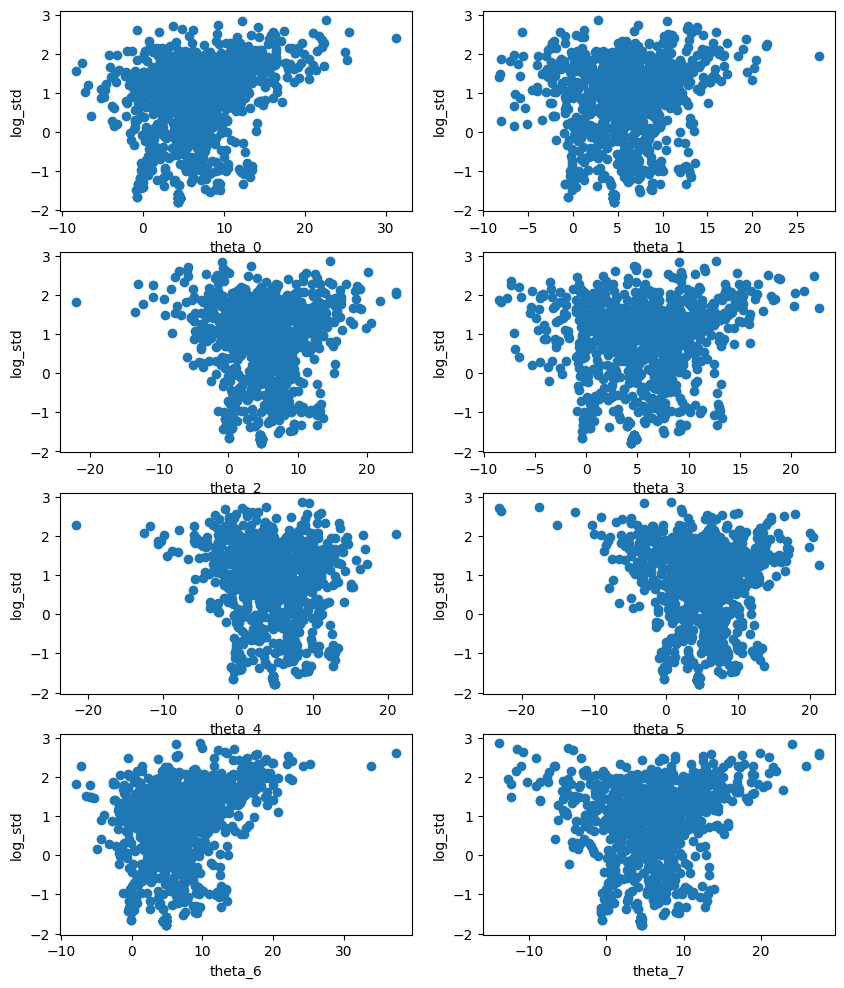

In [ ]:
scatterplt(states[0])

In [ ]:
acceptance_rate = np.mean(infos[0])
num_divergent = np.mean(infos[1])

print(f"\Average acceptance rate: {acceptance_rate:.2f}")
print(f"There were {100*num_divergent:.2f}% divergent transitions")

\Average acceptance rate: 0.91
There were 1.30% divergent transitions


In [ ]:
raise ValueError("This is a custom value error.")

ValueError: This is a custom value error.

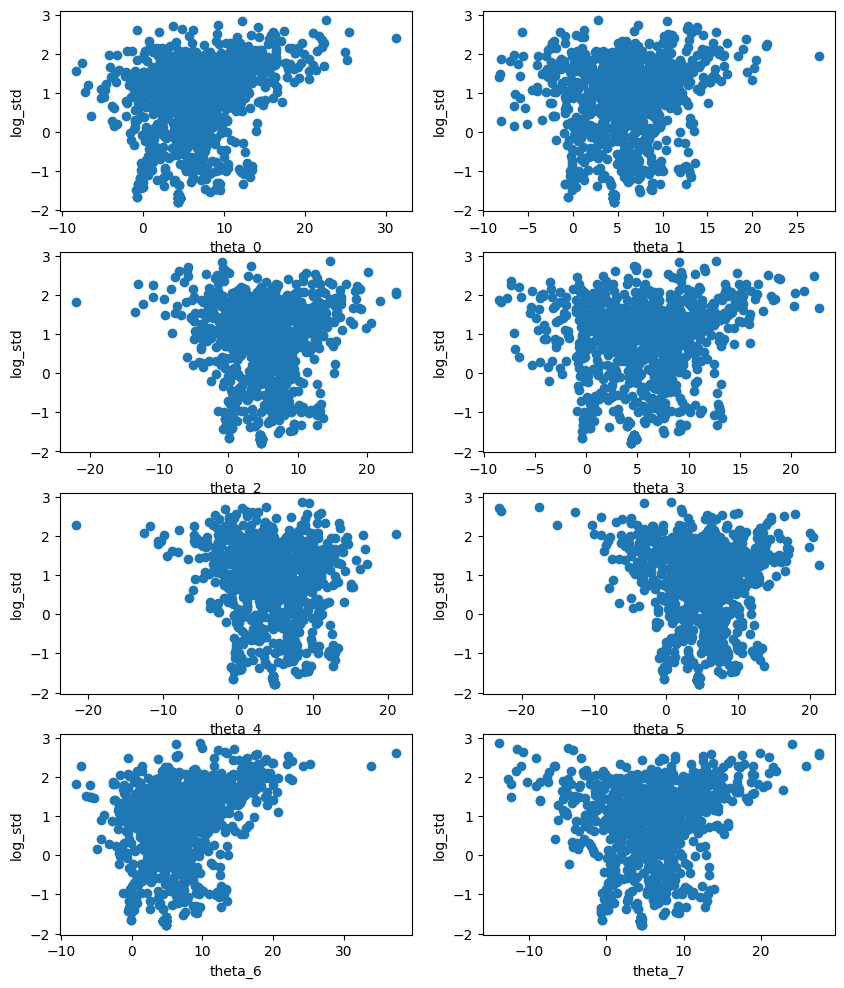

In [ ]:
scatterplt(states[0])

In [ ]:
acceptance_rate = np.mean(infos[0])
num_divergent = np.mean(infos[1])

print(f"\Average acceptance rate: {acceptance_rate:.2f}")
print(f"There were {100*num_divergent:.2f}% divergent transitions")

\Average acceptance rate: 0.86
There were 0.10% divergent transitions
